<a href="https://colab.research.google.com/github/Doctor9Trio/ANN_Fight_detection/blob/main/CNN_Fight_detecion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# `CNN Video Fight Detection`


In [69]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [70]:
!git clone https://github.com/Doctor9Trio/ANN_Fight_detection.git
#!git clone https://github.com/Doctor9Trio/video_fight_detection_Datasets

fatal: destination path 'video_fight_detection_Datasets' already exists and is not an empty directory.


In [71]:
folder_paths = ['/content/ANN_Fight_detection/fight', '/content/ANN_Fight_detection/no_fight']
#folder_paths = ['/content/video_fight_detection_Datasets/fight', '/content/video_fight_detection_Datasets/nofight']


In [72]:
try:
# creating a folder named data
  if not os.path.exists('data1'):
    os.makedirs('data1')

# if not created then raise error
except OSError:
  print ('Error: Creating directory of data')

In [73]:
import glob
label=[]
images=[]
no=0
l=0
# Process videos from each folder
for folder_path in folder_paths:
    os.chdir(folder_path)  # Set the current working directory to the folder

    # List the video files in the folder (you can adjust the file extension)
    video_files = glob.glob(os.path.join(folder_path,"*.avi"))
    for video_file in video_files:
     #   video_name = os.path.splitext(os.path.basename(video_file))[0]

        # Process the video
        cam = cv2.VideoCapture(video_file)

        currentframe = 0

        while (currentframe < 7):
            ret, frame = cam.read()
            if ret:
                name = '/content/data1/frame' + str(no) + '.jpg'
                img = frame
                img = cv2.resize(img, (224, 224))  # Resize the image to 224x224 pixels
                cv2.imwrite(name, frame)
                images.append(img)
                currentframe += 1
                no+=1
                label.append(l)
            else:
                break

        cam.release()
        cv2.destroyAllWindows()
    l+=1
    print(f'Processing of videos in {folder_path} is complete.')


Processing of videos in /content/video_fight_detection_Datasets/fight is complete.
Processing of videos in /content/video_fight_detection_Datasets/nofight is complete.


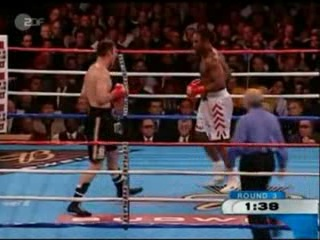

240 320


In [74]:
img = cv2.imread('/content/data1/frame25.jpg')
from google.colab.patches import cv2_imshow
cv2_imshow(img)
# get width and height
print(img.shape[0],img.shape[1])

In [75]:
# Modify your CustomDataset class to apply transformations to a single image
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        if self.transform:
            x = self.transform(x)

        return x, y

# Define data transformations with the correct mean and std
# Replace 'mean' and 'std' with the appropriate values for your dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [76]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(100352, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [77]:
X = np.array(images)
y = label

X = torch.from_numpy(X)
y = torch.tensor(y)

X = X.float()
X = X.permute(0, 3, 1, 2)
dataset = CustomDataset(X,y, transform=transform)

#Split the dataset into training and validation
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 25
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [78]:
print(X.shape)

torch.Size([308, 3, 224, 224])


In [79]:
# Create a CNN model
model = SimpleCNN()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

     # Save the model after each epoch
    torch.save(model.state_dict(), f'fight_detection_model_epoch_{epoch + 1}.pth')



Epoch 1, Loss: 24.623599231243134
Epoch 2, Loss: 0.6752149403095246
Epoch 3, Loss: 0.3166156649589539
Epoch 4, Loss: 0.032729442603886126
Epoch 5, Loss: 0.0006373543463212173


Load Trained Model

In [80]:
# Load the saved model
model = SimpleCNN()  # Create an instance of your model
# Load the state dictionary with weights_only=True
state_dict = torch.load('fight_detection_model_epoch_5.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.eval() # Set the model to evaluation mode

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [81]:
# Test loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


Accuracy: 100.0%
